# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=";")

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [5]:
azdias.shape

(891221, 85)

In [6]:
azdias.columns.to_series().groupby(azdias.dtypes).groups

{dtype('int64'): Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
        'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
        'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GEBURTSJAHR',
        'GREEN_AVANTGARDE', 'HEALTH_TYP', 'NATIONALITAET_KZ',
        'PRAEGENDE_JUGENDJAHRE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
        'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
        'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
        'SEMIO_TRADV', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP'],
       dtype='object'),
 dtype('float64'): Index(['CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'LP_LEBENSPHASE_FEIN',
        'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
        'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'RETOURTYP_BK_S', 'SOHO_KZ',
        'TITEL_KZ', 'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL',
        'HH_EINKOMMEN_SCORE', 'KK_KUNDENTYP', 'W_KEIT_KIND_HH',
        'WOHNDAUER_2008', 'ANZ_HAU

In [7]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# Identify missing or unknown data values and convert them to NaNs.
def print_null(data, n=0):
    print(data.isnull().sum(axis=n)[data.isnull().sum(axis=n) != 0])
    print("Total nulls:", data.isnull().sum(axis=n).sum())

print_null(azdias)

CJT_GESAMTTYP            4854
GFK_URLAUBERTYP          4854
LP_LEBENSPHASE_FEIN      4854
LP_LEBENSPHASE_GROB      4854
LP_FAMILIE_FEIN          4854
LP_FAMILIE_GROB          4854
LP_STATUS_FEIN           4854
LP_STATUS_GROB           4854
RETOURTYP_BK_S           4854
SOHO_KZ                 73499
TITEL_KZ                73499
ALTER_HH                73499
ANZ_PERSONEN            73499
ANZ_TITEL               73499
HH_EINKOMMEN_SCORE      18348
KK_KUNDENTYP           584612
W_KEIT_KIND_HH         107602
WOHNDAUER_2008          73499
ANZ_HAUSHALTE_AKTIV     93148
ANZ_HH_TITEL            97008
GEBAEUDETYP             93148
KONSUMNAEHE             73969
MIN_GEBAEUDEJAHR        93148
OST_WEST_KZ             93148
WOHNLAGE                93148
CAMEO_DEUG_2015         98979
CAMEO_DEU_2015          98979
CAMEO_INTL_2015         98979
KBA05_ANTG1            133324
KBA05_ANTG2            133324
KBA05_ANTG3            133324
KBA05_ANTG4            133324
KBA05_BAUMAX           133324
KBA05_GBZ 

In [9]:
%%time
for col_index in range(azdias.shape[1]):
    col_name = azdias.columns[col_index].strip()
    missing_or_unknown_list = feat_info.iloc[col_index, 3]
    missing_or_unknown_list = missing_or_unknown_list.strip("[").strip("]").strip().split(sep=",")    
    if missing_or_unknown_list == [""]:
        continue
    else:
        for index in missing_or_unknown_list:
            if col_name in azdias.columns and azdias[col_name].dtype == "object":
                azdias.loc[azdias[col_name] == index, col_name] = np.nan
            elif col_name in azdias.columns:
                index = int(index)
                azdias.loc[azdias[col_name] == index, col_name] = np.nan
            else:
                print(col_name)

CPU times: user 9.18 s, sys: 14.9 s, total: 24 s
Wall time: 24.1 s


In [10]:
print_null(azdias)

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
CJT_GESAMTTYP              4854
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SHOPPER_TYP              111196
SOHO_KZ                   73499
TITEL_KZ                 889061
VERS_TYP                 111196
ALTER_HH                 310267
ANZ_PERSONEN              73499
ANZ_TITEL                 73499
HH_EINKOMMEN_SCORE        18348
KK_KUNDENTYP             584612
W_KEIT_KIND_HH           147988
WOHNDAUER_2008            73499
ANZ_HAUSHALTE_AKTIV       99611
ANZ_HH_TITEL              97008
GEBAEUDETYP               93148
KONSUMNAEHE               73969
                          ...  
OST_WEST

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
null_col_df = pd.DataFrame((azdias.isnull().sum() / azdias.shape[0])*100, 
                           index=azdias.columns, columns=["col_null_percentage"])
null_col_df.head()

,col_null_percentage
AGER_TYP,76.955435
ALTERSKATEGORIE_GROB,0.323264
ANREDE_KZ,0.000000
CJT_GESAMTTYP,0.544646
FINANZ_MINIMALIST,0.000000


In [12]:
null_col_df[null_col_df["col_null_percentage"] != 0].describe()

,col_null_percentage
count,61.000000
mean,15.403309
std,17.627446
min,0.323264
25%,10.451729
50%,11.147852
75%,13.073637
max,99.757636


Text(0.5,1,'Top 20 Columns with Null Percentage (sorted from most to least)')

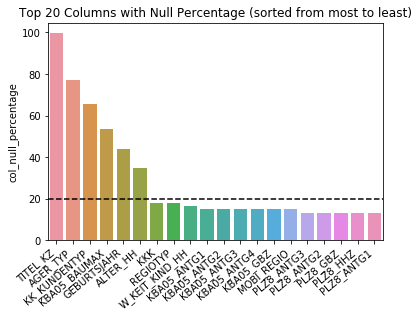

In [13]:
# Investigate patterns in the amount of missing data in each column.
sns.barplot(y="col_null_percentage", x=null_col_df.index, data=null_col_df, 
            order=null_col_df.sort_values("col_null_percentage", ascending=False).iloc[:20].index)
plt.xticks(rotation=40, ha="right")
plt.axhline(y=20, color="k", linestyle="--")
plt.title("Top 20 Columns with Null Percentage (sorted from most to least)")

In [14]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
col_null_percentage_over_20 = null_col_df[null_col_df["col_null_percentage"] > 20].index
print(col_null_percentage_over_20)
azdias = azdias.drop(col_null_percentage_over_20, axis=1)
azdias.head()

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

We can see that there are 61 columns with null value and the average null percentage is 15.4%. However, most columns did not passed the 20% mark on null value percentage. The 5 columns passing the mark are the following columns: 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'. I have noticed that 'TITEL_KZ' has the most missing values (almost 100%), while the others are at least 30%. The 5 columns are dropped accordingly.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [15]:
# How much data is missing in each row of the dataset?
print_null(azdias, 1)

0         43
3          7
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
20        10
23         8
24        47
25         5
26        19
29         2
30        34
34         4
35        43
39         5
40         4
42         2
46        40
48        47
53        43
54        47
60         4
61        43
62        43
64         5
          ..
891129     8
891130    34
891135     6
891136     2
891137    34
891139     7
891140    34
891150     3
891154    11
891155     4
891157     4
891159    43
891161     3
891162     6
891164    43
891169    18
891170    19
891171    34
891172    16
891173    19
891175    47
891181     3
891184     8
891185    47
891187    47
891203    14
891208     3
891216     3
891217     4
891218     5
Length: 268012, dtype: int64
Total nulls: 5035304


In [16]:
null_row_df = pd.DataFrame((azdias.isnull().sum(axis=1) / azdias.shape[1])*100, columns=["row_null_percentage"])
null_row_df.head()

,row_null_percentage
0,54.430380
1,0.000000
2,0.000000
3,8.860759
4,0.000000


Text(0.5,1,'Top 20 Rows with Null Percentage (sorted from most to least)')

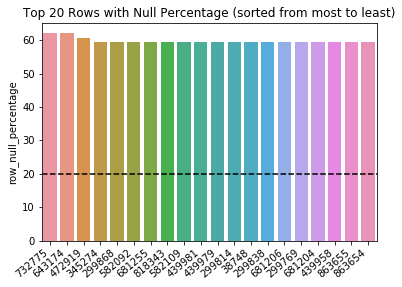

In [17]:
sns.barplot(y="row_null_percentage", x=null_row_df.index, data=null_row_df, 
            order=null_row_df.sort_values("row_null_percentage", ascending=False).iloc[:20].index)
plt.xticks(rotation=40, ha="right")
plt.axhline(y=20, color="k", linestyle="--")
plt.title("Top 20 Rows with Null Percentage (sorted from most to least)")

Text(0.5,1,'Rows with Null value (Count)')

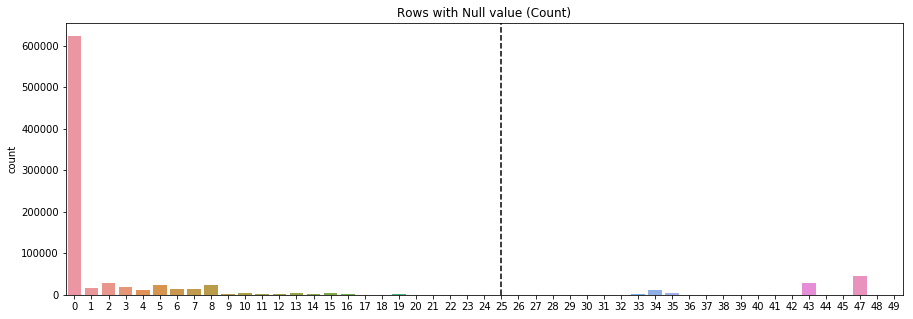

In [18]:
plt.figure(figsize=(15,5))
sns.countplot(azdias.isnull().sum(axis=1))
plt.axvline(x=25, color="k", linestyle="--")
plt.title("Rows with Null value (Count)")

Text(0.5,1,'Rows with Null value (Null Percentage)')

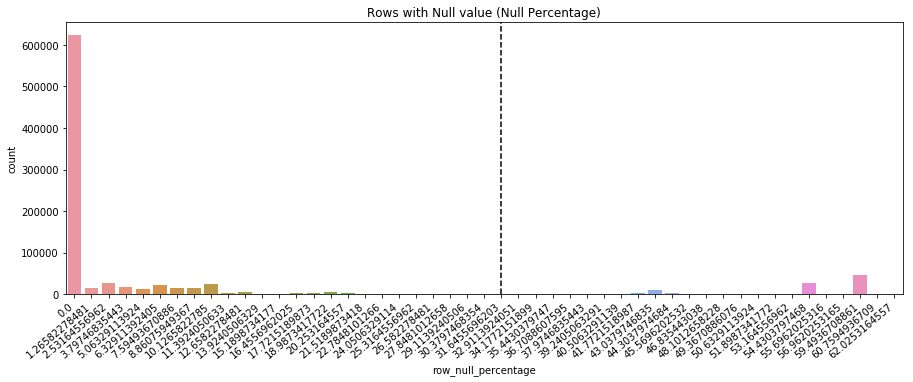

In [19]:
plt.figure(figsize=(15,5))
sns.countplot(null_row_df["row_null_percentage"])
plt.xticks(rotation=40, ha="right")
plt.axvline(x=25, color="k", linestyle="--")
plt.title("Rows with Null value (Null Percentage)")

Picked the "25 null values" mark as the splitting point. (Shown in the plots)

In [20]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_under_25 = azdias[azdias.isnull().sum(axis=1) <= 25]
azdias_over_25 = azdias[azdias.isnull().sum(axis=1) > 25]

Random picked 5 columns

In [21]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
np.random.seed(35) #39
non_null_col_list = null_col_df[null_col_df == 0].index.tolist()
non_null_cols = [non_null_col_list[i] for i in np.random.choice(len(non_null_col_list), 5, replace=False)]
print(non_null_cols)

['GREEN_AVANTGARDE', 'VERS_TYP', 'PRAEGENDE_JUGENDJAHRE', 'GEBAEUDETYP', 'SEMIO_KULT']


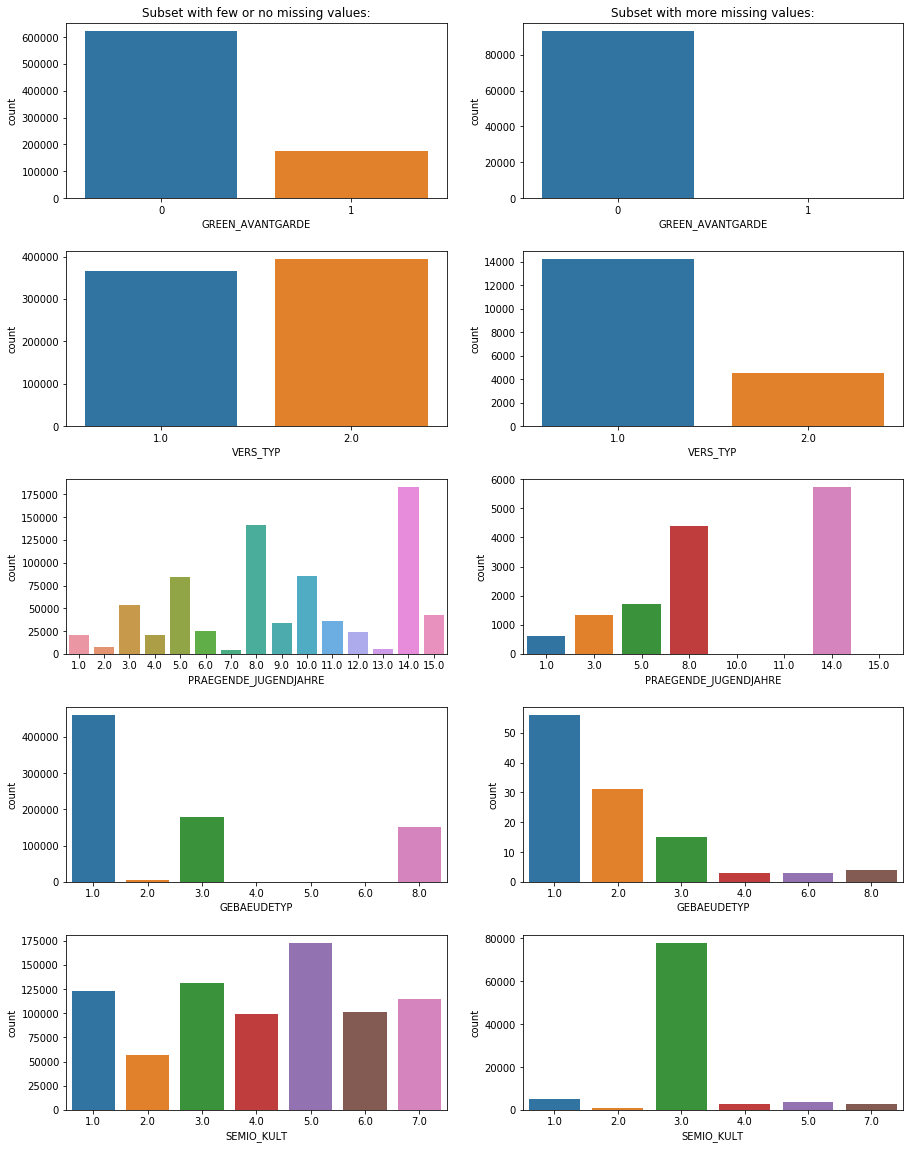

In [22]:
fig, ax = plt.subplots(nrows=len(non_null_cols), ncols=2, figsize=(15,20))
fig.subplots_adjust(hspace=0.3)
for i in range(len(non_null_cols)):
    if non_null_cols[i] in azdias_under_25.columns and non_null_cols[i] in azdias_over_25.columns:
        ax[0][0].set_title("Subset with few or no missing values:")
        ax[0][1].set_title("Subset with more missing values:")
        sns.countplot(azdias_under_25[non_null_cols[i]], ax=ax[i][0])
        sns.countplot(azdias_over_25[non_null_cols[i]], ax=ax[i][1])

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

The columns picked are 'GREEN_AVANTGARDE', 'VERS_TYP', 'PRAEGENDE_JUGENDJAHRE', 'GEBAEUDETYP', 'SEMIO_KULT'.

While only two of the subsets look similar (that is 'GREEN_AVANTGARDE', 'PRAEGENDE_JUGENDJAHRE'), subsets with columns such as 'VERS_TYP', 'GEBAEUDETYP', 'SEMIO_KULT' yield hugh difference. This implies that we need to be careful of misjudging null values, which may lead to bias.

- 'GREEN_AVANTGARDE' is the Membership in environmental sustainability as part of youth for a person. We can see that the subset with more missing values contain less people that have memberships. But in the other subset that has less or no missing values, there are at least some people that are typically members of green avantgarde.
- 'VERS_TYP' means Insurance typology. Hugh differences in that the subset with more missing values have more people that are social-safety driven, while the other subset have slightly more people that have individualistic-accepting risks.
- 'PRAEGENDE_JUGENDJAHRE' stands for Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west). The subsets are similar in a way that both of them have high percentage in people that have experience in the two topics: 70s - family orientation (Mainstream, E+W) and 90s - digital media kids (Mainstream, E+W). These two (8 and 14) accounts for the majority of the counts.
- 'GEBAEUDETYP' is the Type of building (residential vs. commercial). The main difference between the subsets is that the subset with less or no missing values have overwhelming amount distributed to residential buildings, but the other subset is have a third of the amount in residential buildings without actually known household.
- 'SEMIO_KULT' is the Personality typology. Most people in the subset with more missing values are high affinity, but the other subsets is faily distributed.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [23]:
# How many features are there of each data type?
#feat_info["type"].value_counts()
feat_info.groupby("type")["type"].count()

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
Name: type, dtype: int64

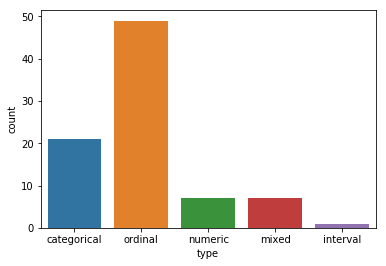

In [24]:
sns.countplot("type", data=feat_info)

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [25]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [26]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_col_list = feat_info.loc[feat_info["type"] == "categorical", "attribute"].values
print(cat_col_list)

['AGER_TYP' 'ANREDE_KZ' 'CJT_GESAMTTYP' 'FINANZTYP' 'GFK_URLAUBERTYP'
 'GREEN_AVANTGARDE' 'LP_FAMILIE_FEIN' 'LP_FAMILIE_GROB' 'LP_STATUS_FEIN'
 'LP_STATUS_GROB' 'NATIONALITAET_KZ' 'SHOPPER_TYP' 'SOHO_KZ' 'TITEL_KZ'
 'VERS_TYP' 'ZABEOTYP' 'KK_KUNDENTYP' 'GEBAEUDETYP' 'OST_WEST_KZ'
 'CAMEO_DEUG_2015' 'CAMEO_DEU_2015']


In [27]:
col_null_percentage_over_20

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')

In [28]:
# Re-encode categorical variable(s) to be kept in the analysis.
non_num_2_cat = []
multi_cat = []
for col in cat_col_list:
    if col in azdias.columns:
        if azdias[col].nunique() == 2:
            non_num_2_cat.append(col)
        elif azdias[col].nunique() > 2:
            multi_cat.append(col)
        
print("Binary variable with non-numeric values:", non_num_2_cat, "\nMulti-level categoricals:", multi_cat)

Binary variable with non-numeric values: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ'] 
Multi-level categoricals: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [29]:
for col in non_num_2_cat:
    if azdias[col].unique().dtype.type is np.object_:
        print("{}: {}".format(col, azdias[col].unique()))
    else:
        print("{}: {}".format(col, np.sort(azdias[col].unique())))

ANREDE_KZ: [ 1.  2.]
GREEN_AVANTGARDE: [0 1]
SOHO_KZ: [  0.   1.  nan]
VERS_TYP: [  1.   2.  nan]
OST_WEST_KZ: [nan 'W' 'O']


In [30]:
azdias["ANREDE_KZ"].replace([2.,1.], [1,0], inplace=True)
azdias["VERS_TYP"].replace([2.,1.], [1,0], inplace=True)
azdias["OST_WEST_KZ"].replace(['W','O'], [1,0], inplace=True)

In [31]:
for col in multi_cat:
    if azdias[col].unique().dtype.type is np.object_:
        print("{}: {}".format(col, azdias[col].unique()))
    else:
        print("{}: {}".format(col, np.sort(azdias[col].unique())))

CJT_GESAMTTYP: [  1.   2.   3.   4.   5.   6.  nan]
FINANZTYP: [ 1.  2.  3.  4.  5.  6.]
GFK_URLAUBERTYP: [  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  nan]
LP_FAMILIE_FEIN: [  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  nan]
LP_FAMILIE_GROB: [  1.   2.   3.   4.   5.  nan]
LP_STATUS_FEIN: [  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  nan]
LP_STATUS_GROB: [  1.   2.   3.   4.   5.  nan]
NATIONALITAET_KZ: [  1.   2.   3.  nan]
SHOPPER_TYP: [  0.   1.   2.   3.  nan]
ZABEOTYP: [ 1.  2.  3.  4.  5.  6.]
GEBAEUDETYP: [  1.   2.   3.   4.   5.   6.   8.  nan]
CAMEO_DEUG_2015: [nan '8' '4' '2' '6' '1' '9' '5' '7' '3']
CAMEO_DEU_2015: [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C']


Will not deal with Multi-level categoricals!

```Python
azdias["AGER_TYP"].replace([-1,1,2,3], [1,2,3,4], inplace=True)
azdias["SHOPPER_TYP"].replace([0,1,2,3], [1,2,3,4], inplace=True)
azdias["SHOPPER_TYP"].replace([8], [7], inplace=True)
azdias["CAMEO_DEUG_2015"].replace(['8','4','2','6','1','9','5','7','3'], [8,4,2,6,1,9,5,7,3], inplace=True)
```

```Python
CAMEO_DEU_2015_dummies = pd.get_dummies(azdias["CAMEO_DEU_2015"])
azdias = pd.concat([azdias, CAMEO_DEU_2015_dummies], axis=1).head()
azdias = azdias.drop("CAMEO_DEU_2015", axis=1)
```

In [32]:
for col in multi_cat:
    if col in azdias.columns:
        azdias = azdias.drop(col, axis=1)

In [33]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,0.0,3.0,4.0,3.0,5.0,5.0,3.0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,1.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,1.0,4.0,2.0,5.0,2.0,1.0,2.0,0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,0.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

- Binary (two-level) categoricals that take numeric values: do nothing.
- Binary variable that takes on non-numeric values: re-encode the values as numbers.
- Multi-level categoricals (three or more values): Do not do multiple dummy variables (OneHotEncoder), but drop all the multi-level features.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [34]:
mixed_col_list = feat_info.loc[feat_info["type"] == "mixed", "attribute"].values
print(mixed_col_list)

['LP_LEBENSPHASE_FEIN' 'LP_LEBENSPHASE_GROB' 'PRAEGENDE_JUGENDJAHRE'
 'WOHNLAGE' 'CAMEO_INTL_2015' 'KBA05_BAUMAX' 'PLZ8_BAUMAX']


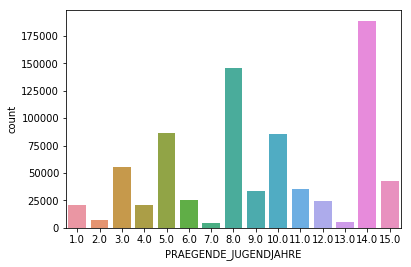

In [35]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
sns.countplot("PRAEGENDE_JUGENDJAHRE", data=azdias)

In [36]:
# MOVEMENT
azdias.loc[azdias["PRAEGENDE_JUGENDJAHRE"].isin([1,3,5,8,10,12,14]), "MOVEMENT"] = 1
azdias.loc[azdias["PRAEGENDE_JUGENDJAHRE"].isin([2,4,6,7,9,11,13,15]), "MOVEMENT"] = 0

# DECADE
azdias.loc[azdias["PRAEGENDE_JUGENDJAHRE"].isin([1,2]), "DECADE"] = 1
azdias.loc[azdias["PRAEGENDE_JUGENDJAHRE"].isin([3,4]), "DECADE"] = 2
azdias.loc[azdias["PRAEGENDE_JUGENDJAHRE"].isin([5,6,7]), "DECADE"] = 3
azdias.loc[azdias["PRAEGENDE_JUGENDJAHRE"].isin([8,9]), "DECADE"] = 4
azdias.loc[azdias["PRAEGENDE_JUGENDJAHRE"].isin([10,11,12,13]), "DECADE"] = 5
azdias.loc[azdias["PRAEGENDE_JUGENDJAHRE"].isin([14,15]), "DECADE"] = 6

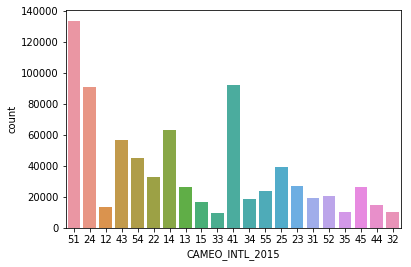

In [37]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
sns.countplot("CAMEO_INTL_2015", data=azdias)

In [38]:
# WEALTH
azdias.loc[azdias["CAMEO_INTL_2015"].isin(["51","52","53","54","55"]), "WEALTH"] = 1
azdias.loc[azdias["CAMEO_INTL_2015"].isin(["41","42","43","44","45"]), "WEALTH"] = 2
azdias.loc[azdias["CAMEO_INTL_2015"].isin(["31","32","33","34","35"]), "WEALTH"] = 3
azdias.loc[azdias["CAMEO_INTL_2015"].isin(["21","22","23","24","25"]), "WEALTH"] = 4 
azdias.loc[azdias["CAMEO_INTL_2015"].isin(["11","12","13","14","15"]), "WEALTH"] = 5

# LIFE_STAGE
azdias.loc[azdias["CAMEO_INTL_2015"].isin(["11","21","31","41","51"]), "LIFE_STAGE"] = 1
azdias.loc[azdias["CAMEO_INTL_2015"].isin(["12","22","32","42","52"]), "LIFE_STAGE"] = 2
azdias.loc[azdias["CAMEO_INTL_2015"].isin(["13","23","33","43","53"]), "LIFE_STAGE"] = 3
azdias.loc[azdias["CAMEO_INTL_2015"].isin(["14","24","34","44","54"]), "LIFE_STAGE"] = 4
azdias.loc[azdias["CAMEO_INTL_2015"].isin(["15","25","35","45","55"]), "LIFE_STAGE"] = 5

In [39]:
for col in mixed_col_list:
    if col in azdias.columns:
        azdias = azdias.drop(col, axis=1)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

The Mixed-Type Features are: 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX'.
- Remove: 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX'
- Reencode and drop: 'PRAEGENDE_JUGENDJAHRE' into MOVEMENT (1 and 0) and DECADE (6 periods of decades), 'CAMEO_INTL_2015' into WEALTH and LIFE_STAGE of 5 levels

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [40]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MOVEMENT,DECADE,WEALTH,LIFE_STAGE
0,2.0,0.0,3.0,4.0,3.0,5.0,5.0,3.0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,1.0,6.0,1.0,1.0
2,3.0,1.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,0.0,6.0,4.0,4.0
3,4.0,1.0,4.0,2.0,5.0,2.0,1.0,2.0,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,1.0,4.0,5.0,2.0
4,3.0,0.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,1.0,4.0,2.0,3.0


In [41]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'KBA05_ANTG1', 'KBA05_ANTG2',
       'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE',
       'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1',
       'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ',
       'ARBEI

In [42]:
azdias.shape

(891221, 64)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [43]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    print("convert missing value codes into NaNs")
    for col_index in range(df.shape[1]):
        col_name = df.columns[col_index].strip()  
        if missing_or_unknown_list == [""]:
            continue
        else:
            for index in missing_or_unknown_list:
                if col_name in df.columns and df[col_name].dtype == "object":
                    df.loc[df[col_name] == index, col_name] = np.nan
                elif col_name in df.columns:
                    index = int(index)
                    df.loc[df[col_name] == index, col_name] = np.nan
                else:
                    print(col_name)

    for col in df.columns:
        df = df.replace({col: ["XX","X"]}, np.nan) 

    # remove selected columns and rows, ...
    print("remove selected columns and rows")
    df = df.drop(col_null_percentage_over_20, axis=1)
    
    # select, re-encode, and engineer column values.
    print("select, re-encode, and engineer column values")
    df["ANREDE_KZ"].replace([2.,1.], [1,0], inplace=True)
    df["VERS_TYP"].replace([2.,1.], [1,0], inplace=True)
    df["OST_WEST_KZ"].replace(['W','O'], [1,0], inplace=True)
    
    non_num_2_cat = []
    multi_cat = []
    for col in cat_col_list:
        if col in df.columns:
            if df[col].nunique() == 2:
                non_num_2_cat.append(col)
            elif df[col].nunique() > 2:
                multi_cat.append(col)

    for col in multi_cat:
        if col in df.columns:
            df = df.drop(col, axis=1)            
    
    # MOVEMENT
    df.loc[df["PRAEGENDE_JUGENDJAHRE"].isin([1,3,5,8,10,12,14]), "MOVEMENT"] = 1
    df.loc[df["PRAEGENDE_JUGENDJAHRE"].isin([2,4,6,7,9,11,13,15]), "MOVEMENT"] = 0

    # DECADE
    df.loc[df["PRAEGENDE_JUGENDJAHRE"].isin([1,2]), "DECADE"] = 1
    df.loc[df["PRAEGENDE_JUGENDJAHRE"].isin([3,4]), "DECADE"] = 2
    df.loc[df["PRAEGENDE_JUGENDJAHRE"].isin([5,6,7]), "DECADE"] = 3
    df.loc[df["PRAEGENDE_JUGENDJAHRE"].isin([8,9]), "DECADE"] = 4
    df.loc[df["PRAEGENDE_JUGENDJAHRE"].isin([10,11,12,13]), "DECADE"] = 5
    df.loc[df["PRAEGENDE_JUGENDJAHRE"].isin([14,15]), "DECADE"] = 6

    # WEALTH
    df.loc[df["CAMEO_INTL_2015"].isin(["51","52","53","54","55"]), "WEALTH"] = 1
    df.loc[df["CAMEO_INTL_2015"].isin(["41","42","43","44","45"]), "WEALTH"] = 2
    df.loc[df["CAMEO_INTL_2015"].isin(["31","32","33","34","35"]), "WEALTH"] = 3
    df.loc[df["CAMEO_INTL_2015"].isin(["21","22","23","24","25"]), "WEALTH"] = 4 
    df.loc[df["CAMEO_INTL_2015"].isin(["11","12","13","14","15"]), "WEALTH"] = 5

    # LIFE_STAGE
    df.loc[df["CAMEO_INTL_2015"].isin(["11","21","31","41","51"]), "LIFE_STAGE"] = 1
    df.loc[df["CAMEO_INTL_2015"].isin(["12","22","32","42","52"]), "LIFE_STAGE"] = 2
    df.loc[df["CAMEO_INTL_2015"].isin(["13","23","33","43","53"]), "LIFE_STAGE"] = 3
    df.loc[df["CAMEO_INTL_2015"].isin(["14","24","34","44","54"]), "LIFE_STAGE"] = 4
    df.loc[df["CAMEO_INTL_2015"].isin(["15","25","35","45","55"]), "LIFE_STAGE"] = 5
    
    for col in mixed_col_list:
        if col in df.columns:
            df = df.drop(col, axis=1)
        
    # Return the cleaned dataframe.
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [44]:
print_null(azdias)

ALTERSKATEGORIE_GROB      2881
HEALTH_TYP              111196
RETOURTYP_BK_S            4854
SOHO_KZ                  73499
VERS_TYP                111196
ANZ_PERSONEN             73499
ANZ_TITEL                73499
HH_EINKOMMEN_SCORE       18348
W_KEIT_KIND_HH          147988
WOHNDAUER_2008           73499
ANZ_HAUSHALTE_AKTIV      99611
ANZ_HH_TITEL             97008
KONSUMNAEHE              73969
MIN_GEBAEUDEJAHR         93148
OST_WEST_KZ              93148
KBA05_ANTG1             133324
KBA05_ANTG2             133324
KBA05_ANTG3             133324
KBA05_ANTG4             133324
KBA05_GBZ               133324
BALLRAUM                 93740
EWDICHTE                 93740
INNENSTADT               93740
GEBAEUDETYP_RASTER       93155
KKK                     158064
MOBI_REGIO              133324
ONLINE_AFFINITAET         4854
REGIOTYP                158064
KBA13_ANZAHL_PKW        105800
PLZ8_ANTG1              116515
PLZ8_ANTG2              116515
PLZ8_ANTG3              116515
PLZ8_ANT

In [45]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.preprocessing import Imputer, StandardScaler

# For those numeric variables having NAs, we used median to replace the NAs
imp = Imputer(strategy='median')
imputed_azdias = imp.fit_transform(azdias)
imputed_azdias.shape

(891221, 64)

In [46]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaled_azdias = scaler.fit_transform(imputed_azdias)
scaled_azdias.shape

(891221, 64)

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

missing value: chose to use median for the imputer because mean is bad if there are outliers. All of the data is then scaled (mean=0 and standard deviation=1).

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [47]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
azdias_pca = pca.fit_transform(scaled_azdias)

CPU times: user 121 ms, sys: 0 ns, total: 121 ms
Wall time: 208 ms


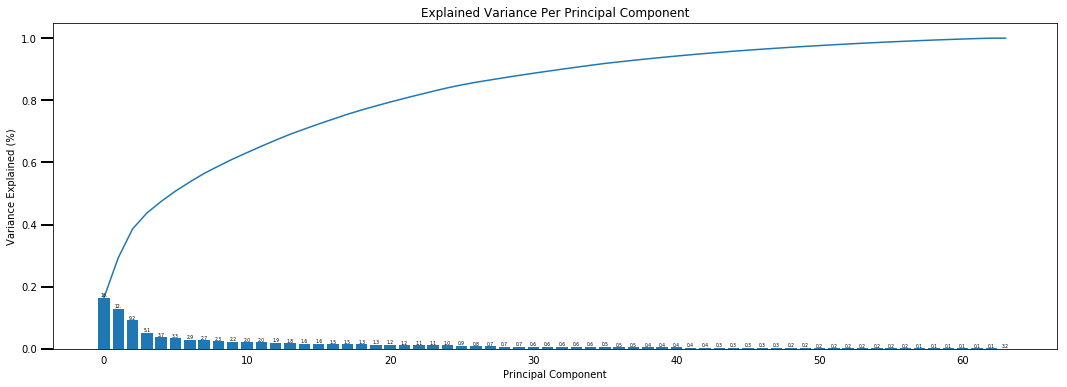

In [48]:
%%time
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(18, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s" % ((str(vals[i]*100)[:3])), (ind[i], vals[i]), va="bottom", ha="center", fontsize=4.5)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

scree_plot(pca)

In [49]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(30)
azdias_pca = pca.fit_transform(scaled_azdias)

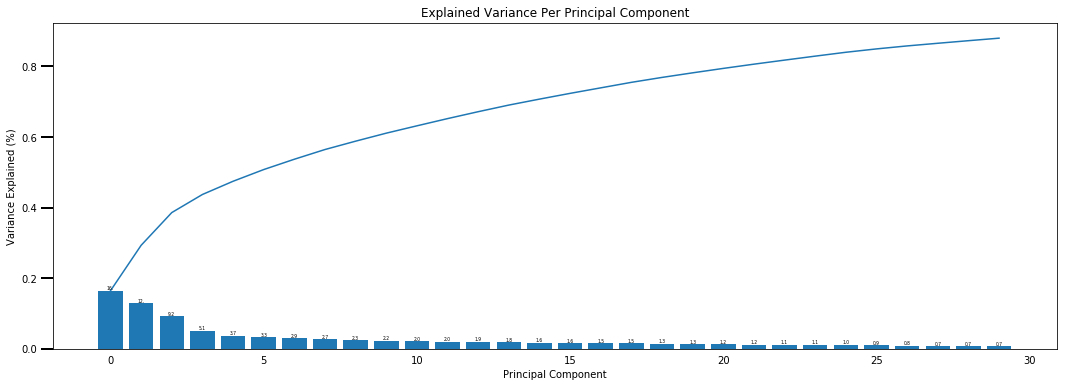

In [50]:
scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

principal components / transformed features: 30, variance explained: 85%. This value is chosen because the it has 85% of the variance explained and will reduce the dimension to about 50%.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

PLZ8_ANTG3            0.2318
PLZ8_ANTG4            0.2249
ORTSGR_KLS9           0.2007
EWDICHTE              0.2006
HH_EINKOMMEN_SCORE    0.1737
FINANZ_MINIMALIST    -0.2175
KBA05_GBZ            -0.2205
KBA05_ANTG1          -0.2271
PLZ8_ANTG1           -0.2316
MOBI_REGIO           -0.2455
Name: 0, dtype: float64


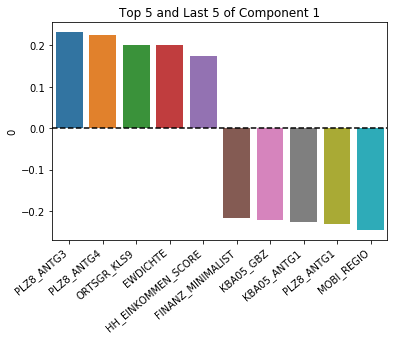

In [51]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def map_pca_components(data, pca, n=0):
    components = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()).iloc[n]
    components.sort_values(ascending=False, inplace=True)
    components = pd.concat([components.head(5), components.tail(5)])
    print(components)
    
    sns.barplot(y=components, x=components.index)
    plt.xticks(rotation=40, ha="right")
    plt.axhline(y=0, color="k", linestyle="--")
    plt.title("Top 5 and Last 5 of Component " + str(n+1))
    
map_pca_components(azdias, pca, 0)

ALTERSKATEGORIE_GROB    0.2684
FINANZ_VORSORGER        0.2477
SEMIO_ERL               0.2249
SEMIO_LUST              0.1858
RETOURTYP_BK_S          0.1725
SEMIO_TRADV            -0.2344
SEMIO_PFLICHT          -0.2413
SEMIO_REL              -0.2491
FINANZ_SPARER          -0.2522
DECADE                 -0.2595
Name: 1, dtype: float64


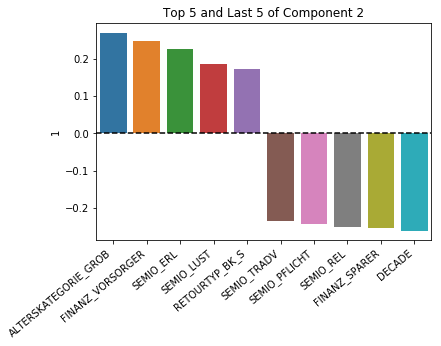

In [52]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_pca_components(azdias, pca, 1)

SEMIO_VERT           0.3537
SEMIO_SOZ            0.2913
SEMIO_KULT           0.2790
SEMIO_FAM            0.2316
FINANZ_MINIMALIST    0.1295
FINANZ_ANLEGER      -0.1805
SEMIO_KRIT          -0.3076
SEMIO_DOM           -0.3295
SEMIO_KAEM          -0.3561
ANREDE_KZ           -0.3573
Name: 2, dtype: float64


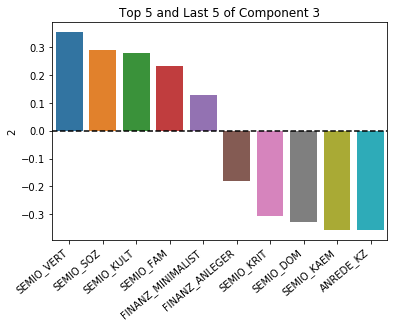

In [53]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_pca_components(azdias, pca, 2)

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

Principal Component 1: This component is about living and housing with positive association in the number living in 6-10+ family houses and negitive association for those in 1-2 family houses. There are also other relevant features such as community size and density that accounts for this component.
- positive association: 
    * 'PLZ8_ANTG3' (Number of 6-10 family houses in the PLZ8 region)
    * 'PLZ8_ANTG4' (Number of 10+ family houses in the PLZ8 region)
    * 'ORTSGR_KLS9' (Size of community)
    * 'EWDICHTE' (Density of households per square kilometer)
    * 'HH_EINKOMMEN_SCORE' (Estimated household net income)
- negitive association: 
    * 'FINANZ_MINIMALIST' (Financial typology)
    * 'KBA05_GBZ' (Number of buildings in the microcell)
    * 'KBA05_ANTG1' (Number of 1-2 family houses in the microcell)
    * 'PLZ8_ANTG1' (Number of 1-2 family houses in the PLZ8 region)
    * 'MOBI_REGIO' (Movement patterns)

Principal Component 2: This component is based on age, personal traits and financial situations. We can see that estimated age based on given name analysis has the most association and generation by decade has the least association, this is implying that the component is really about age and generation.
- positive association: 
    * 'ALTERSKATEGORIE_GROB' (Estimated age based on given name analysis)
    * 'FINANZ_VORSORGER' (Financial typology)
    * 'SEMIO_ERL' (Personality typology)
    * 'SEMIO_LUST' (Personality typology)
    * 'RETOURTYP_BK_S' (Return type)
- negitive association: 
    * 'SEMIO_TRADV' (Personality typology)
    * 'SEMIO_PFLICHT' (Personality typology)
    * 'SEMIO_REL' (Personality typology)
    * 'FINANZ_SPARER' (Financial typology)
    * 'DECADE' (Generation by decade)

Principal Component 3: This component is about personal traits and gender. The gender feature has the least association and most of the feature are part of the personality typology.
- positive association: 
    * 'SEMIO_VERT' (Personality typology)
    * 'SEMIO_SOZ' (Personality typology)
    * 'SEMIO_KULT' (Personality typology)
    * 'SEMIO_FAM' (Personality typology)
    * 'FINANZ_MINIMALIST' (Financial typology)
- negitive association: 
    * 'FINANZ_ANLEGER' (Financial typology)
    * 'SEMIO_KRIT' (Personality typology)
    * 'SEMIO_DOM' (Personality typology)
    * 'SEMIO_KAEM' (Personality typology)
    * 'ANREDE_KZ' (Gender)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [54]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
azdias_pca_sample = azdias_pca[np.random.choice(azdias_pca.shape[0], int(azdias_pca.shape[0]*0.2), replace=False)]
azdias_pca_sample.shape

(178244, 30)

CPU times: user 18min 59s, sys: 4min 45s, total: 23min 45s
Wall time: 23min 52s


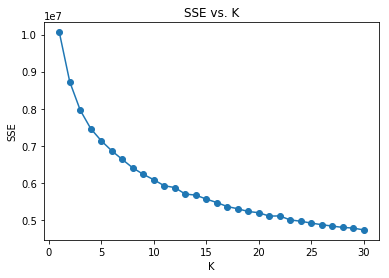

In [55]:
%%time
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
from sklearn.cluster import KMeans

def kmean_score(data, k):
    kmeans = KMeans(n_clusters = k)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

def plot_kmean_score(data):
    score_list = []
    n_clusters_list = list(range(1,31))
    for k in n_clusters_list:
        score_list.append(kmean_score(data, k))
        
    plt.plot(n_clusters_list, score_list, linestyle="-", marker="o");
    plt.xlabel("K");
    plt.ylabel("SSE");
    plt.title("SSE vs. K");

plot_kmean_score(azdias_pca_sample)

In [56]:
%%time
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=15)
kmeans_model = kmeans.fit(azdias_pca)
azdias_labels = kmeans_model.predict(azdias_pca)

CPU times: user 2min 44s, sys: 1min 14s, total: 3min 58s
Wall time: 3min 59s


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

A random sample set of 20% is used to save time on the computation. The elbow is likely at K=15, because after that the decreased SSE is rather small.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [57]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [58]:
customers.columns

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

In [59]:
%%time
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers = clean_data(customers)

convert missing value codes into NaNs
remove selected columns and rows
select, re-encode, and engineer column values
CPU times: user 3min 41s, sys: 31.7 s, total: 4min 13s
Wall time: 4min 14s


In [60]:
customers.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MOVEMENT,DECADE,WEALTH,LIFE_STAGE
0,4.0,0.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,0.0,5.0,5.0,1.0,2.0,1.0,0.0,2.0,5.0,3.0
1,4.0,0.0,5.0,1.0,5.0,1.0,3.0,2.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,1.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,...,1.0,3.0,2.0,3.0,5.0,3.0,0.0,2.0,3.0,4.0
3,4.0,0.0,5.0,1.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,3.0,4.0,1.0,3.0,1.0,1.0,1.0,4.0,4.0
4,3.0,0.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,...,1.0,3.0,3.0,3.0,5.0,1.0,1.0,4.0,2.0,1.0


In [61]:
imputed_customers_df = pd.DataFrame(imp.transform(customers))
imputed_customers_df.columns = customers.columns
imputed_customers_df.index = customers.index
print(imputed_customers_df.shape)

(191652, 64)


In [62]:
scaled_customers_df = pd.DataFrame(scaler.transform(imputed_customers_df), columns=list(imputed_customers_df))
print(scaled_customers_df.shape)

(191652, 64)


In [63]:
customers_pca = pca.transform(scaled_customers_df)

In [64]:
customers_labels = kmeans_model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

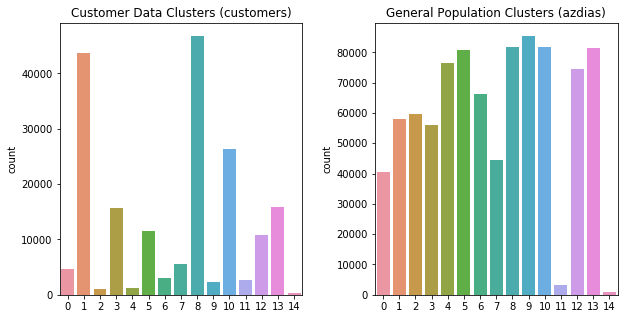

In [65]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
fig.subplots_adjust(hspace=1, wspace=0.3)
ax[0].set_title("Customer Data Clusters (customers)")
ax[1].set_title("General Population Clusters (azdias)")
sns.countplot(customers_labels, ax=ax[0])
sns.countplot(azdias_labels, ax=ax[1])

In [66]:
azdias_labels_count = np.asarray(np.unique(azdias_labels, return_counts=True)).T 
customers_labels_count = np.asarray(np.unique(customers_labels, return_counts=True)).T
count_diff = []
percentage_diff = []
for i in range(len(azdias_labels_count)):
    azdias_labels_percentage = azdias_labels_count[i][1] / len(azdias_labels)
    customers_labels_percentage = customers_labels_count[i][1] / len(customers_labels)
    count_diff.append(azdias_labels_count[i][1] - customers_labels_count[i][1])
    percentage_diff.append((azdias_labels_percentage - customers_labels_percentage)*100)
       
diff_df = pd.DataFrame(list(zip(count_diff, percentage_diff)), columns=["count_diff", "percentage_diff"])
diff_df

,count_diff,percentage_diff
0,35941,2.136457
1,14313,-16.305467
2,58662,6.124712
3,40393,-1.875455
4,75345,7.932745
5,69297,3.067466
6,63092,5.837040
7,38982,2.094723
8,34926,-15.238905
9,83144,8.399901


Text(0.5,1,'Percentage Difference in each Cluster')

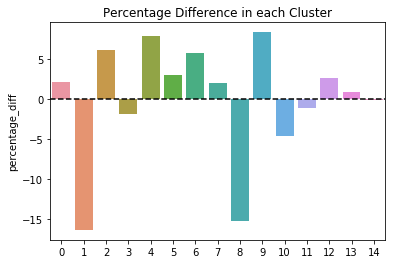

In [67]:
sns.barplot(y="percentage_diff", x=diff_df.index, data=diff_df)
plt.axhline(y=0, color="k", linestyle="--")
plt.title("Percentage Difference in each Cluster")

In [68]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
over_num = diff_df[diff_df["percentage_diff"] == max(diff_df["percentage_diff"])].index[0]
print("Overrepresented Cluster:", over_num, "with overrepresented percentage:", max(diff_df["percentage_diff"]))
cluster_over = scaler.inverse_transform(pca.inverse_transform(kmeans_model.cluster_centers_[over_num]))
pd.Series(data=cluster_over, index=customers.columns).sort_values(ascending=False)

Overrepresented Cluster: 9 with overrepresented percentage: 8.399901472772807


MIN_GEBAEUDEJAHR         1994.231190
KBA13_ANZAHL_PKW          699.051944
WOHNDAUER_2008              7.430677
SEMIO_RAT                   6.197814
SEMIO_DOM                   6.011284
SEMIO_PFLICHT               5.984632
SEMIO_TRADV                 5.763660
SEMIO_KAEM                  5.697314
DECADE                      5.571213
INNENSTADT                  5.486046
SEMIO_KRIT                  5.465693
SEMIO_REL                   5.221427
SEMIO_MAT                   5.092109
BALLRAUM                    4.900063
FINANZ_ANLEGER              4.405325
SEMIO_ERL                   4.404772
REGIOTYP                    4.278500
HH_EINKOMMEN_SCORE          4.072123
ORTSGR_KLS9                 4.030023
GEBAEUDETYP_RASTER          4.006070
SEMIO_KULT                  3.979608
FINANZ_SPARER               3.964924
FINANZ_UNAUFFAELLIGER       3.905275
PLZ8_GBZ                    3.871821
KBA05_GBZ                   3.818641
SEMIO_FAM                   3.795142
MOBI_REGIO                  3.701938
A

In [69]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
under_num = diff_df[diff_df["percentage_diff"] == min(diff_df["percentage_diff"])].index[0]
print("Underrepresented cluster:", under_num, "with underrepresented percentage:", min(diff_df["percentage_diff"]))
cluster_under = scaler.inverse_transform(pca.inverse_transform(kmeans_model.cluster_centers_[under_num]))
pd.Series(data=cluster_under, index=customers.columns).sort_values(ascending=False)

Underrepresented cluster: 1 with underrepresented percentage: -16.305466862783703


MIN_GEBAEUDEJAHR         1993.134978
KBA13_ANZAHL_PKW          691.956800
WOHNDAUER_2008              8.402967
SEMIO_VERT                  6.201154
ORTSGR_KLS9                 5.332085
SEMIO_LUST                  5.261179
SEMIO_SOZ                   5.073102
SEMIO_FAM                   4.883051
SEMIO_KULT                  4.867984
FINANZ_MINIMALIST           4.816736
INNENSTADT                  4.641910
FINANZ_VORSORGER            4.160476
MOBI_REGIO                  4.131027
SEMIO_ERL                   4.099205
KBA05_GBZ                   4.089090
W_KEIT_KIND_HH              4.022466
BALLRAUM                    3.995722
GEBAEUDETYP_RASTER          3.968591
EWDICHTE                    3.927474
PLZ8_GBZ                    3.903653
RETOURTYP_BK_S              3.897968
SEMIO_MAT                   3.897651
WEALTH                      3.851767
SEMIO_REL                   3.748622
PLZ8_HHZ                    3.694558
LIFE_STAGE                  3.636609
DECADE                      3.630874
R

In [70]:
pd.Series(data=cluster_over, index=customers.columns)[["HH_EINKOMMEN_SCORE", "ANREDE_KZ", "ALTERSKATEGORIE_GROB", "KBA13_ANZAHL_PKW"]]

HH_EINKOMMEN_SCORE        4.072123
ANREDE_KZ                 0.982412
ALTERSKATEGORIE_GROB      1.727092
KBA13_ANZAHL_PKW        699.051944
dtype: float64

In [71]:
pd.Series(data=cluster_under, index=customers.columns)[["HH_EINKOMMEN_SCORE", "ANREDE_KZ", "ALTERSKATEGORIE_GROB", "KBA13_ANZAHL_PKW"]]

HH_EINKOMMEN_SCORE        2.433938
ANREDE_KZ                 0.055091
ALTERSKATEGORIE_GROB      3.278591
KBA13_ANZAHL_PKW        691.956800
dtype: float64

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

* Popular/Overrepresented cluster: 9. There is a 8.399901472772807% difference between the clusters of the general data and the cluster data.
* Unpopular/Underrepresented cluster: 1. There is a -16.305466862783703% difference between the clusters of the general data and the cluster data, which is quite hugh.

When we compare some specific features in the two (Popular/Overrepresented vs. Unpopular/Underrepresented):
* HH_EINKOMMEN_SCORE (Estimated household net income):  4.072123 > 2.433938, income is much higher in the overrepresented cluster.
* ANREDE_KZ (Gender): 0.982412 > 0.055091, more females in the overrepresented cluster.
* ALTERSKATEGORIE_GROB (Estimated age based on given name analysis): 1.727092 < 3.2785911187037442, people in the overrepresented cluster (30 - 45 years old) are younger than people in the underrepresented cluster (46 - 60 years old).
* KBA13_ANZAHL_PKW (Number of cars in the PLZ8 region): 699.051944 > 691.956800, people in the underrepresented cluster have slightly less cars.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.